# Week 12: Unsupervised Learning (K-means Clustering)

```
- Machine Learning, Innopolis University (Fall semester 2023)
- Professor: Adil Khan
- Teaching Assistant: Gcinizwe Dlamini
```
<hr>


```
In this lab, you will practice Clustering techniques

Lab Plan
1. K-means
2. K-means++
3. Choosing optimal k
```

<hr>


## 1. K-means

![](https://miro.medium.com/max/1200/1*rw8IUza1dbffBhiA4i0GNQ.png)

K-means is an unsupervised ML technique to cluster unlabeled dataset to k clusters where each datapoint belongs to a cluster with the nearest centroid.

##### Thoughts:
What's the pros and cons of K-means?

<span style="color:blue">
Pros:

1. Scales good with large datasets
2. Guarantees convergence.
3. generalize well with clusters of globular, spherical,or elliptical shapes.

Cons:
1. K has to be chosen manually. (we can use the loss vs the #cluster method)
2. Being dependent on the initial state
3. Not efficient at clustering data with varying densities and sizes.
4. It doesn't scale good when the number of dimensions gets so big as the distance metric will converge to a constant value between any given examples.
(so we may need to reduce dimensions first)

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## 1.1 Data generation

In [2]:
from sklearn.datasets import make_blobs
import pandas as pd
import plotly.express as px

real_centers = [[1,1], [5,5], [8, 1]]
X, y = make_blobs(n_samples=300, centers=real_centers, n_features=2,
                   random_state=0,)

df = pd.DataFrame(X, columns=['Feature 1', 'Feature 2'])
df['label'] = y

fig = px.scatter(df, x='Feature 1', y='Feature 2', title='My Unlabeled Data', marginal_x="histogram", marginal_y="histogram")
fig.show()

## 1.2 Implementing K-means method

### <span style="color:red">Task: implement the fit and predict function of K-means class here.

In [3]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np
from scipy.spatial.distance import cdist
from copy import deepcopy

class KMeans(BaseEstimator, ClassifierMixin):

    def __init__(self, k=3, centers=None):
        self.k = k
        self.centers = centers
        self.init_centers = centers

    def _predict(self, X, centers):
        # (1 line) Calculate the pairwise distance
        # between each sample in X and the centroids.
        distances = cdist(X, centers)
        return np.argmin(distances, axis=1)

    def predict(self, X, y=None):
        return self._predict(X, self.centers)

    def fit(self, X, y=None):
        c = X.shape[1]
        if self.centers is None:
            mean = np.mean(X, axis = 0)
            std = np.std(X, axis = 0)
            self.centers = np.random.randn(self.k, c) * std + mean
            self.init_centers = deepcopy(self.centers)
        centers = self.centers
        centers_new = deepcopy(self.centers) # Store new centers

        error = -1

        # When, after an update, the estimate of that center stays the same, exit loop
        while error != 0:
            # Predict clusters of each point using the current clusters
            clusters = self._predict(X, centers)
            centers_old = deepcopy(centers_new)
            # Calculate mean for every cluster and update the center in 'centers_new'
            for i in range(self.k):
                centers_new [i] = np.mean(X[clusters==i], axis=0)

            error = np.linalg.norm(centers_new - centers_old)
            centers = centers_new
        self.centers = centers_new
        return self

    def score(self, X, y=None):
        return 0


Train and predict K-means model on the generated dataset.

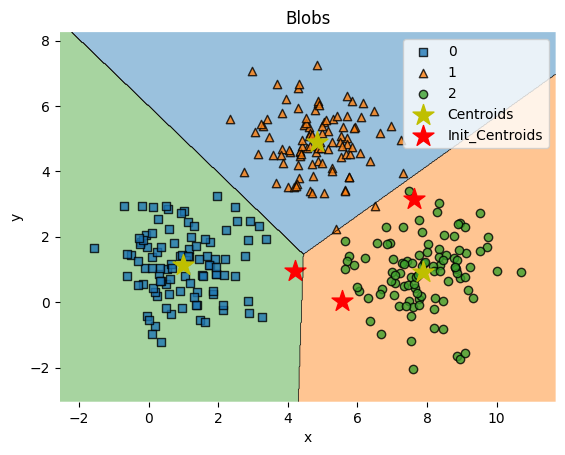

In [4]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt

clf = KMeans(3, None).fit(X,y)
df['Cluster label'] = clf.predict(df.iloc[:,:2]).astype(str)


plot_decision_regions(X=X, y=y, clf=clf, legend=2)
plt.scatter(clf.centers[:,0], clf.centers[:,1], marker='*', c='y', s=250, label='Centroids')
plt.scatter(clf.init_centers[:,0], clf.init_centers[:,1], marker='*', c='r', s=250, label='Init_Centroids')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Blobs')
plt.show()

## Visualize with Plotly

In [5]:
fig = px.scatter(df, x='Feature 1', y='Feature 2', color='Cluster label',
                 color_continuous_scale=["red","green", "blue"],
                 title='Labeled Data', marginal_x="histogram", marginal_y="histogram")
fig.add_scatter(x= clf.centers[:,0], y=clf.centers[:,1],mode='markers',marker=dict(size=20, symbol="x", color='black'), name='Centroid')
fig.show()

## 2. K-Means++

This algorithm is made to solve the problem of initial centroids values.

K-means++
1. Choose one center uniformly at random from among the data points.
2. For each data point x, compute $D(x)$.
3. Choose the next centroid using a weighted probability distribution where a point x is chosen with probability proportional to  $𝐷(𝑥)^2$ .
4. Repeat until you have k points.

$D(x)$: the distance betweem x and the closest center

-----
### <span style="color:red">Task: Implement K-means++ algorithm for selecting the intial points.

In [6]:
from numpy.random import choice


def choose(X, prob):
    # Return one point of X chosen randomly with probablity p
    # USE choise function in np.random (3 lines):
    n = X.shape[0]
    idx = choice(n, 1, p=prob)
    return X[idx]

def kmeans_pp(X, k):
    n = X.shape[0]
    weights = np.ones(n) / n
    centers = []
    while len(centers) < k:
        # Choose a centroid with the current weights
        centroid = choose(X, weights)
        centers.extend(centroid)
        # Calculate the pair-wise distances
        # between the datapoints X and the current centers
        distances = cdist(X, centers)
        # get min distance then square it.
        min = np.min(distances, axis=1)
        # Obtain new probabilities in weights.
        d_squared = min ** 2
        weight = d_squared / d_squared.sum()

        # TODO

    return np.array(centers)

initial_centers = kmeans_pp(X, 3)

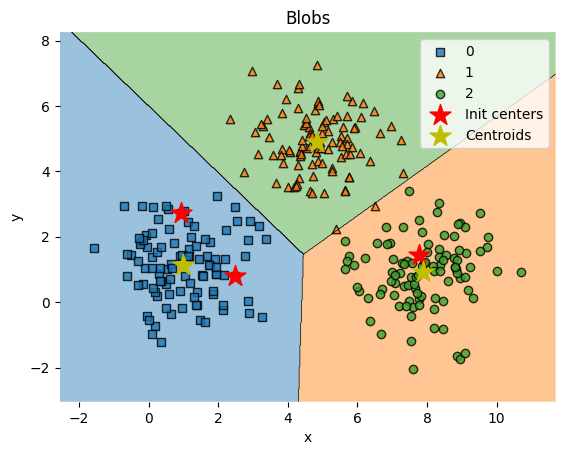

In [7]:
clf = KMeans(3, initial_centers).fit(X,y)

plot_decision_regions(X=X, y=y, clf=clf, legend=2)
plt.scatter(initial_centers[:,0], initial_centers[:,1], marker='*', c='r', s=250,label='Init centers')
plt.scatter(clf.centers[:,0], clf.centers[:,1], marker='*', c='y', s=250,label='Centroids')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Blobs')
plt.show()

## 3. How to choose k

### 3.1 Elbow method:

One way is to plot the sum of squared distances of samples to their centeriods vs number of clusters K.
Then, choose the K which the error doesn't decrease too much after.

In [8]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

X, y = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)
df = pd.DataFrame(X, columns=['Feature 1', 'Feature 2'])

fig = px.scatter(df, x='Feature 1', y='Feature 2', marginal_x="histogram", marginal_y="histogram",
                 color_continuous_scale=["red","green", "blue"],
                 title='My unlabeled data')
fig.show()

In [9]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

fig = px.line(y=wcss, x=range(1, 11), title='Elbow Method',  markers=True)
fig.update_layout(title="Elbow Method", xaxis_title="Number of clusters", yaxis_title="WCSS")
fig.show()

Another way is to measure the silhouette score for the clustering.
This score measures the separability between clusters and the cohesion inside the clusters.

Then, we take the K that has higher score.

## 2.2 Silhouette Score

In [10]:
from sklearn.metrics import silhouette_score
silhouettes = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    y = kmeans.predict(X)
    score = silhouette_score(X, y)
    silhouettes.append(score)


fig = px.line(y=silhouettes, x=range(2, 11), markers=True)
fig.update_layout(title="Silhouette Method", xaxis_title="Number of clusters", yaxis_title="silhouette score")
fig.show()

In [11]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(X)

fig = px.scatter(df, x='Feature 1', y='Feature 2',
                 title='Labeled Data')
fig.add_scatter(x= kmeans.cluster_centers_[:,0], y=kmeans.cluster_centers_[:,1],mode='markers', marker=dict(size=20, symbol="x", color='red'),name='Centroid')
fig.show()

## Self practice task

  

Using [UNSW-NB15 Dataset](https://www.dropbox.com/s/nsvgwps3abdoxnq/clustering_data.zip?dl=1):

1. Preprocess the dataset
2. Reduce dimension using PCA
3. Remove outliers
4. Cluster the data using K-means (find the optimal number of k)
5. Visualize the data clusters (use PCA with 2 components)